# 🚀 Email Phishing Detection - Feature Engineering & Evaluation

**Complete Pipeline: From Cleaned Data → Automatically Selected Features**

## Overview

This notebook:
1. **Creates 15 engineered features** from cleaned email data
2. **Evaluates all features** using multiple methods:
   - Feature Importance (Random Forest)
   - Statistical Significance Tests
   - Information Value (IV)
3. **Automatically selects optimal features** based on:
   - Statistical significance (p < 0.05)
   - Feature importance threshold (> 0.01)
   - Cumulative importance (elbow point or 80% threshold)

---

## Table of Contents

### Part 1: Feature Engineering
- 1.1 Setup & Data Loading
- 1.2 Original Features (5 existing features)
- 1.3 Temporal Risk Scores (2 features)
- 1.4 Regional Features (3 features)
- 1.5 Sender Volume Features (4 features)
- 1.6 Sender Temporal Features (2 features)
- 1.7 Sender Newness Feature (0 features - combined into 1.5)
- 1.8 Interaction Features (1 feature)
- 1.9 Final Dataset Assembly (15 features + target)

### Part 2: Feature Evaluation & Selection
- 2.1 Data Preparation
- 2.2 Feature Importance (Random Forest)
- 2.3 Statistical Significance Tests
- 2.4 Information Value (Optional)
- 2.5 Automatic Feature Selection
- 2.6 Comprehensive Visualizations
- 2.7 Summary

---


---
# 📦 PART 1: FEATURE ENGINEERING
---

## 1.1 Setup & Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [2]:
# ============================================================
# LOAD YOUR CLEANED DATA
# ============================================================

file_path = "cleaned_date_merged_data.csv"

print("="*80)
print("LOADING CLEANED DATA")
print("="*80)

df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])

print(f"\n✅ Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\n📊 Label Distribution:")
print(df['label'].value_counts())
print(f"\n   Phishing rate: {df['label'].mean()*100:.2f}%")

# Display first few rows
df.head()

LOADING CLEANED DATA

✅ Data loaded: 48,803 rows × 16 columns
   Date range: 1990-01-01 17:57:46 to 2022-12-27 10:56:49

📊 Label Distribution:
label
1    27406
0    21397
Name: count, dtype: int64

   Phishing rate: 56.16%


,sender,receiver,date,subject,body,label,urls,timezone_hours,timezone_region,year,month,day,hour,day_of_week,day_name,is_weekend
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,2008-08-06 07:31:02,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,-7.0000,Americas,2008,8,6,7,2,Wednesday,0
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,2008-08-06 07:31:03,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,-5.0000,Americas,2008,8,6,7,2,Wednesday,0
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,2008-08-06 16:28:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,-12.0000,Americas,2008,8,6,16,2,Wednesday,0
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,2008-08-06 07:31:20,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,-6.0000,Americas,2008,8,6,7,2,Wednesday,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,2008-08-06 07:31:21,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,-4.0000,Europe/Africa,2008,8,6,7,2,Wednesday,0


In [3]:
# Verify required columns exist
required_cols = ['sender', 'date', 'label', 'hour', 'day_of_week', 'month', 
                 'is_weekend', 'timezone_region']

print("Checking required columns:")
for col in required_cols:
    if col in df.columns:
        print(f"   ✅ {col}: {df[col].dtype}, {df[col].nunique()} unique values")
    else:
        print(f"   ❌ MISSING: {col}")

missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")
else:
    print(f"\n✅ All required columns present!")

Checking required columns:
   ✅ sender: object, 30756 unique values
   ✅ date: datetime64[ns], 45189 unique values
   ✅ label: int64, 2 unique values
   ✅ hour: int64, 24 unique values
   ✅ day_of_week: int64, 7 unique values
   ✅ month: int64, 12 unique values
   ✅ is_weekend: int64, 2 unique values
   ✅ timezone_region: object, 5 unique values

✅ All required columns present!


## 1.2 Original Features (Already Exist)

These features are already in your cleaned data:
- `hour` (0-23): Hour email was sent
- `day_of_week` (0-6): Day of week (0=Monday, 6=Sunday)
- `month` (1-12): Month email was sent *(removed from final features)*
- `is_weekend` (0/1): Binary flag for weekend
- `timezone_region`: Geographic region (categorical)

**Note:** We'll remove `month` in the final assembly as it showed low information value and may be dataset-specific.


In [4]:
# Verify original features
original_features = ['hour', 'day_of_week', 'month', 'is_weekend', 'timezone_region']

print("="*80)
print("ORIGINAL FEATURES")
print("="*80)

for feature in original_features:
    print(f"\n{feature}:")
    print(f"   Type: {df[feature].dtype}")
    print(f"   Unique values: {df[feature].nunique()}")
    print(f"   Range: {df[feature].min()} to {df[feature].max()}")
    if df[feature].nunique() < 20:
        print(f"   Distribution:\n{df[feature].value_counts().head()}")

print(f"\n✅ {len(original_features)} original features verified")

ORIGINAL FEATURES

hour:
   Type: int64
   Unique values: 24
   Range: 0 to 23

day_of_week:
   Type: int64
   Unique values: 7
   Range: 0 to 6
   Distribution:
day_of_week
2    15519
3    14560
4    12866
1     2274
0     1446
Name: count, dtype: int64

month:
   Type: int64
   Unique values: 12
   Range: 1 to 12
   Distribution:
month
8     40711
9      1815
7      1545
10     1078
5       639
Name: count, dtype: int64

is_weekend:
   Type: int64
   Unique values: 2
   Range: 0 to 1
   Distribution:
is_weekend
0    46665
1     2138
Name: count, dtype: int64

timezone_region:
   Type: object
   Unique values: 5
   Range: APAC to Oceania/Pacific
   Distribution:
timezone_region
Europe/Africa             27446
Americas                  12751
Middle East/South Asia     4776
APAC                       2844
Oceania/Pacific             986
Name: count, dtype: int64

✅ 5 original features verified


## 1.3 Temporal Risk Scores

Calculate historical phishing rates for different time periods:
- `hour_risk_score`: Phishing rate for each hour (0-23)
- `weekday_risk_score`: Phishing rate for each weekday (0-6)

In [5]:
print("="*80)
print("CREATING TEMPORAL RISK SCORES")
print("="*80)

# Hour Risk Score
hour_risk = df.groupby('hour')['label'].mean()
df['hour_risk_score'] = df['hour'].map(hour_risk)

print(f"\n✅ hour_risk_score created")
print(f"   Range: [{df['hour_risk_score'].min():.3f}, {df['hour_risk_score'].max():.3f}]")
print(f"   Mean: {df['hour_risk_score'].mean():.3f}")

# Weekday Risk Score
weekday_risk = df.groupby('day_of_week')['label'].mean()
df['weekday_risk_score'] = df['day_of_week'].map(weekday_risk)

print(f"\n✅ weekday_risk_score created")
print(f"   Range: [{df['weekday_risk_score'].min():.3f}, {df['weekday_risk_score'].max():.3f}]")
print(f"   Mean: {df['weekday_risk_score'].mean():.3f}")

# Display risk scores
print(f"\n📊 Hour Risk Scores:")
print(hour_risk.to_frame('phishing_rate'))

print(f"\n📊 Weekday Risk Scores:")
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_risk_df = pd.DataFrame({
    'day': weekday_names,
    'phishing_rate': weekday_risk.values
})
print(weekday_risk_df)

CREATING TEMPORAL RISK SCORES

✅ hour_risk_score created
   Range: [0.368, 0.672]
   Mean: 0.562

✅ weekday_risk_score created
   Range: [0.524, 0.705]
   Mean: 0.562

📊 Hour Risk Scores:
      phishing_rate
hour               
0            0.5998
1            0.6540
2            0.6406
3            0.6293
4            0.6217
5            0.5364
6            0.5333
7            0.5062
8            0.3676
9            0.4877
10           0.4497
11           0.5087
12           0.5071
13           0.5070
14           0.5110
15           0.5109
16           0.6152
17           0.6552
18           0.6164
19           0.6178
20           0.6382
21           0.6092
22           0.6721
23           0.6125

📊 Weekday Risk Scores:
         day  phishing_rate
0     Monday         0.6189
1    Tuesday         0.5712
2  Wednesday         0.5502
3   Thursday         0.5819
4     Friday         0.5242
5   Saturday         0.6667
6     Sunday         0.7051


## 1.4 Regional Features

Create regional risk features:
- `region_risk_score`: Historical phishing rate by region
- `is_middle_east`: Binary flag for Middle East/South Asia (93% phishing rate!)

In [6]:
print("="*80)
print("CREATING REGIONAL FEATURES")
print("="*80)

# Region Risk Score
region_risk = df.groupby('timezone_region')['label'].mean()
df['region_risk_score'] = df['timezone_region'].map(region_risk)

print(f"\n✅ region_risk_score created")
print(f"   Range: [{df['region_risk_score'].min():.3f}, {df['region_risk_score'].max():.3f}]")

# Is Middle East Flag
df['is_middle_east'] = (df['timezone_region'] == 'Middle East/South Asia').astype(int)

print(f"\n✅ is_middle_east created")
print(f"   Distribution: {df['is_middle_east'].value_counts().to_dict()}")

# Display regional statistics
print(f"\n📊 Regional Phishing Rates:")
regional_stats = df.groupby('timezone_region').agg({
    'label': ['count', 'sum', 'mean']
})
regional_stats.columns = ['total_emails', 'phishing_count', 'phishing_rate']
regional_stats = regional_stats.sort_values('phishing_rate', ascending=False)
print(regional_stats)

CREATING REGIONAL FEATURES

✅ region_risk_score created
   Range: [0.072, 0.932]

✅ is_middle_east created
   Distribution: {0: 44027, 1: 4776}

📊 Regional Phishing Rates:
                        total_emails  phishing_count  phishing_rate
timezone_region                                                    
Middle East/South Asia          4776            4453         0.9324
APAC                            2844            2175         0.7648
Europe/Africa                  27446           16379         0.5968
Americas                       12751            4328         0.3394
Oceania/Pacific                  986              71         0.0720


## 1.5 Sender Volume Features

Analyze sender behavior by volume:
- `sender_historical_phishing_rate`: Historical phishing rate (time-aware, no leakage)
- `sender_historical_count`: Total historical emails from sender
- `is_first_sender_email`: Binary flag for sender's first email
- `is_burst_sender`: Binary flag for rapid-fire senders

**⚠️ CRITICAL:** Uses time-aware approach to prevent data leakage!


In [7]:
print("="*80)
print("CREATING TIME-AWARE SENDER FEATURES (NO LEAKAGE!)")
print("="*80)

# Sort by sender and date (CRITICAL for time-awareness)
df = df.sort_values(['sender', 'date']).reset_index(drop=True)

print(f"\n📊 Data sorted by sender and date for time-aware calculation")

# ============================================================
# TIME-AWARE: Calculate sender historical phishing rate
# For each email, use ONLY emails that came BEFORE it
# ============================================================

# Count previous emails for this sender (0 for first, 1 for second, etc.)
df['sender_historical_count'] = df.groupby('sender').cumcount()

# Calculate cumulative phishing count
df['_cumsum_phishing'] = df.groupby('sender')['label'].cumsum()

# Shift to get PREVIOUS phishing count (excludes current email)
df['_prev_phishing'] = df.groupby('sender')['_cumsum_phishing'].shift(1).fillna(0)

# Calculate time-aware rate: previous_phishing / previous_count
df['sender_historical_phishing_rate'] = np.where(
    df['sender_historical_count'] > 0,
    df['_prev_phishing'] / df['sender_historical_count'],
    np.nan  # First email from sender has no history
)

# Handle first-time senders: fill NaN with global baseline
global_baseline = df['label'].mean()
first_email_count = df['sender_historical_phishing_rate'].isna().sum()

print(f"\n✅ sender_historical_phishing_rate created")
print(f"   Range: [{df['sender_historical_phishing_rate'].min():.3f}, {df['sender_historical_phishing_rate'].max():.3f}]")
print(f"   Mean: {df['sender_historical_phishing_rate'].mean():.3f}")
print(f"   First emails (no history): {first_email_count:,} ({first_email_count/len(df)*100:.1f}%)")
print(f"   Filling NaN with global baseline: {global_baseline:.3f}")

df['sender_historical_phishing_rate'].fillna(global_baseline, inplace=True)

# Create first email indicator
df['is_first_sender_email'] = (df['sender_historical_count'] == 0).astype(int)

print(f"\n✅ is_first_sender_email created")
print(f"   Distribution: {df['is_first_sender_email'].value_counts().to_dict()}")

# Clean up temporary columns
df.drop(['_cumsum_phishing', '_prev_phishing'], axis=1, inplace=True)

# ============================================================
# OTHER SENDER VOLUME FEATURES
# ============================================================

# Calculate sender statistics (still useful, no leakage since not using label)
sender_stats = df.groupby('sender').agg({
    'label': ['count', 'sum'],  # We'll use count, but ignore sum here
    'date': ['min', 'max']
}).reset_index()

sender_stats.columns = ['sender', 'total_emails', 'phishing_count', 'first_email', 'last_email']

print(f"\n📊 Sender statistics calculated for {len(sender_stats):,} unique senders")

# Merge sender_total_emails
df = df.merge(sender_stats[['sender', 'total_emails']], on='sender', how='left')
df.rename(columns={'total_emails': 'sender_total_emails'}, inplace=True)

print(f"\n✅ sender_total_emails created")
print(f"   Range: [{df['sender_total_emails'].min():.0f}, {df['sender_total_emails'].max():.0f}]")
print(f"   Mean: {df['sender_total_emails'].mean():.2f}")
print(f"   Median: {df['sender_total_emails'].median():.0f}")

# Calculate burst sender flag
sender_stats['activity_span_days'] = (sender_stats['last_email'] - sender_stats['first_email']).dt.days + 1
sender_stats['emails_per_day'] = sender_stats['total_emails'] / sender_stats['activity_span_days']

df = df.merge(sender_stats[['sender', 'emails_per_day']], on='sender', how='left')
df['is_burst_sender'] = (df['emails_per_day'] >= 10).astype(int)
df.drop('emails_per_day', axis=1, inplace=True)

print(f"\n✅ is_burst_sender created")
print(f"   Distribution: {df['is_burst_sender'].value_counts().to_dict()}")

# ============================================================
# COMPARISON: Time-Aware vs What We Would Have Had (Leaky)
# ============================================================
print(f"\n" + "="*80)
print("COMPARISON: TIME-AWARE vs LEAKY APPROACH")
print("="*80)

# Calculate what the leaky version would be (for comparison only, not used in model)
sender_leaky = df.groupby('sender')['label'].mean().reset_index()
sender_leaky.columns = ['sender', '_leaky_rate']
df_compare = df.merge(sender_leaky, on='sender', how='left')

# Show statistics
print(f"\n📊 Leaky Version (OLD - NOT USED):")
print(f"   Mean: {df_compare['_leaky_rate'].mean():.4f}")
print(f"   Std: {df_compare['_leaky_rate'].std():.4f}")
print(f"   All emails from same sender have SAME rate")

print(f"\n📊 Time-Aware Version (NEW - USED IN MODEL):")
print(f"   Mean: {df['sender_historical_phishing_rate'].mean():.4f}")
print(f"   Std: {df['sender_historical_phishing_rate'].std():.4f}")
print(f"   Each email has DIFFERENT rate based on history")

# Calculate correlation with label
from scipy.stats import pointbiserialr
corr_leaky, p_leaky = pointbiserialr(df_compare['label'], df_compare['_leaky_rate'])
corr_time, p_time = pointbiserialr(df['label'], df['sender_historical_phishing_rate'])

print(f"\n📊 Correlation with phishing label:")
print(f"   Leaky version: {corr_leaky:.4f} (p={p_leaky:.4e}) ⚠️  Artificially high!")
print(f"   Time-aware version: {corr_time:.4f} (p={p_time:.4e}) ✅ Realistic!")

if corr_leaky > corr_time:
    diff_pct = ((corr_leaky - corr_time) / corr_time) * 100
    print(f"\n⚠️  Leaky version has {diff_pct:.1f}% higher correlation")
    print(f"   This is evidence of TARGET LEAKAGE!")
    print(f"   Time-aware version prevents this leakage ✅")

# Show example for one sender
example_sender = df['sender'].value_counts().index[10]  # Pick a sender with multiple emails
example = df[df['sender'] == example_sender].head(5)
print(f"\n💡 Example: First 5 emails from {example_sender}")
print("\nTime-aware rate changes as history grows:")
print(example[['date', 'label', 'sender_historical_count', 'sender_historical_phishing_rate']].to_string(index=False))

# Clean up comparison column
df.drop('_leaky_rate', axis=1, inplace=True, errors='ignore')

print(f"\n✅ TIME-AWARE SENDER FEATURES COMPLETE!")
print("="*80)


CREATING TIME-AWARE SENDER FEATURES (NO LEAKAGE!)

📊 Data sorted by sender and date for time-aware calculation

✅ sender_historical_phishing_rate created
   Range: [0.000, 1.000]
   Mean: 0.077
   First emails (no history): 30,756 (63.0%)
   Filling NaN with global baseline: 0.562

✅ is_first_sender_email created
   Distribution: {1: 30756, 0: 18047}

📊 Sender statistics calculated for 30,756 unique senders

✅ sender_total_emails created
   Range: [1, 460]
   Mean: 20.97
   Median: 1

✅ is_burst_sender created
   Distribution: {0: 42109, 1: 6694}

COMPARISON: TIME-AWARE vs LEAKY APPROACH

📊 Leaky Version (OLD - NOT USED):
   Mean: 0.5616
   Std: 0.4961
   All emails from same sender have SAME rate

📊 Time-Aware Version (NEW - USED IN MODEL):
   Mean: 0.3823
   Std: 0.2845
   Each email has DIFFERENT rate based on history

📊 Correlation with phishing label:
   Leaky version: 0.9998 (p=0.0000e+00) ⚠️  Artificially high!
   Time-aware version: 0.8007 (p=0.0000e+00) ✅ Realistic!

⚠️  Leaky

## 1.6 Sender Temporal Features

Analyze sender timing patterns:
- `sender_avg_time_gap`: Average hours between consecutive emails
- `sender_time_gap_std`: Standard deviation of time gaps (irregularity measure)

In [8]:
print("="*80)
print("CREATING SENDER TEMPORAL FEATURES")
print("="*80)

# Sort by sender and date
df_sorted = df.sort_values(['sender', 'date']).copy()

# Calculate time gap between consecutive emails
df_sorted['time_gap_hours'] = df_sorted.groupby('sender')['date'].diff().dt.total_seconds() / 3600

# Calculate statistics per sender
sender_time_gaps = df_sorted.groupby('sender')['time_gap_hours'].agg(['mean', 'std']).reset_index()
sender_time_gaps.columns = ['sender', 'avg_time_gap', 'time_gap_std']

print(f"\n📊 Time gap statistics calculated for {len(sender_time_gaps):,} senders")

# Merge average time gap
df = df.merge(sender_time_gaps[['sender', 'avg_time_gap']], on='sender', how='left')
df.rename(columns={'avg_time_gap': 'sender_avg_time_gap'}, inplace=True)
df['sender_avg_time_gap'].fillna(0, inplace=True)  # Fill NaN for single-email senders

print(f"\n✅ sender_avg_time_gap created")
print(f"   Range: [{df['sender_avg_time_gap'].min():.1f}, {df['sender_avg_time_gap'].max():.1f}] hours")
print(f"   Mean: {df['sender_avg_time_gap'].mean():.1f} hours")
print(f"   Median: {df['sender_avg_time_gap'].median():.1f} hours")

# Merge time gap std
df = df.merge(sender_time_gaps[['sender', 'time_gap_std']], on='sender', how='left')
df.rename(columns={'time_gap_std': 'sender_time_gap_std'}, inplace=True)
df['sender_time_gap_std'].fillna(0, inplace=True)

print(f"\n✅ sender_time_gap_std created")
print(f"   Range: [{df['sender_time_gap_std'].min():.1f}, {df['sender_time_gap_std'].max():.1f}] hours")
print(f"   Mean: {df['sender_time_gap_std'].mean():.1f} hours")

# EDA insight comparison
normal_avg_gap = df[df['label'] == 0]['sender_avg_time_gap'].mean()
spam_avg_gap = df[df['label'] == 1]['sender_avg_time_gap'].mean()
print(f"\n💡 EDA Insight:")
print(f"   Normal sender avg gap: {normal_avg_gap:.1f} hours")
print(f"   Spam sender avg gap: {spam_avg_gap:.1f} hours")
print(f"   → Spammers wait {spam_avg_gap/normal_avg_gap:.1f}x longer between emails!")

CREATING SENDER TEMPORAL FEATURES

📊 Time gap statistics calculated for 30,756 senders

✅ sender_avg_time_gap created
   Range: [0.0, 124632.5] hours
   Mean: 23.8 hours
   Median: 0.0 hours

✅ sender_time_gap_std created
   Range: [0.0, 22739.8] hours
   Mean: 17.9 hours

💡 EDA Insight:
   Normal sender avg gap: 21.1 hours
   Spam sender avg gap: 25.9 hours
   → Spammers wait 1.2x longer between emails!


## 1.7 Sender Newness Feature

**Note:** This feature (`is_first_email`) is now created in Section 1.5 as `is_first_sender_email` to avoid duplication.

The logic remains the same:
- Detects if this is a sender's first email
- Binary flag (1 = first email from this sender)
- Time-aware to prevent leakage


In [9]:
print("="*80)
print("CREATING SENDER NEWNESS FEATURE")
print("="*80)

# Sort by sender and date
df_sorted = df.sort_values(['sender', 'date']).copy()

# Mark first email from each sender
df_sorted['is_first_email'] = ~df_sorted.duplicated(subset='sender', keep='first')
df_sorted['is_first_email'] = df_sorted['is_first_email'].astype(int)

# Merge back to original dataframe
df['is_first_email'] = df_sorted['is_first_email'].values

print(f"\n✅ is_first_email created")
print(f"   Distribution: {df['is_first_email'].value_counts().to_dict()}")

# EDA insight
first_email_spam_rate = df[df['is_first_email'] == 1]['label'].mean()
recurring_spam_rate = df[df['is_first_email'] == 0]['label'].mean()
print(f"\n💡 EDA Insight:")
print(f"   First email spam rate: {first_email_spam_rate:.1%}")
print(f"   Recurring email spam rate: {recurring_spam_rate:.1%}")
print(f"   → First emails are {(first_email_spam_rate-recurring_spam_rate)*100:.1f}% more likely to be spam")

CREATING SENDER NEWNESS FEATURE



✅ is_first_email created
   Distribution: {1: 30756, 0: 18047}

💡 EDA Insight:
   First email spam rate: 84.6%
   Recurring email spam rate: 7.7%
   → First emails are 76.9% more likely to be spam


## 1.8 Interaction Features

Capture cross-dimensional patterns:
- `region_hour_risk`: Phishing rate for (region, hour) combination

In [10]:
print("="*80)
print("CREATING INTERACTION FEATURES")
print("="*80)

# Calculate region × hour risk
region_hour_risk = df.groupby(['timezone_region', 'hour'])['label'].mean()

# Map to dataframe
df['region_hour_risk'] = df.apply(
    lambda row: region_hour_risk.get((row['timezone_region'], row['hour']), df['label'].mean()),
    axis=1
)

print(f"\n✅ region_hour_risk created")
print(f"   Range: [{df['region_hour_risk'].min():.3f}, {df['region_hour_risk'].max():.3f}]")
print(f"   Mean: {df['region_hour_risk'].mean():.3f}")

# Show some high-risk combinations
print(f"\n💡 Top 5 Highest Risk (Region, Hour) Combinations:")
top_combos = region_hour_risk.nlargest(5)
for (region, hour), risk in top_combos.items():
    print(f"   {region:30s} at {hour:2d}:00 → {risk:.1%} spam")

CREATING INTERACTION FEATURES

✅ region_hour_risk created
   Range: [0.000, 0.989]
   Mean: 0.562

💡 Top 5 Highest Risk (Region, Hour) Combinations:
   Middle East/South Asia         at 16:00 → 98.9% spam
   Middle East/South Asia         at  3:00 → 97.9% spam
   Middle East/South Asia         at  2:00 → 97.6% spam
   Middle East/South Asia         at 20:00 → 96.8% spam
   Middle East/South Asia         at 22:00 → 96.2% spam


## 1.9 Final Dataset Assembly

Create final feature set with **15 features + target**

### Feature Breakdown:
1. **Original Temporal (3):** `hour`, `day_of_week`, `is_weekend`
   - *Removed:* `month` (low IV, dataset-specific)
2. **Temporal Risk Scores (2):** `hour_risk_score`, `weekday_risk_score`
3. **Regional Features (3):** `timezone_region`, `region_risk_score`, `is_middle_east`
4. **Time-Aware Sender (4):** `sender_historical_phishing_rate_time_aware`, `sender_historical_count`, `is_first_sender_email`, `is_burst_sender`
5. **Sender Temporal (2):** `sender_avg_time_gap`, `sender_time_gap_std`
6. **Interaction (1):** `region_hour_risk`

**Total:** 15 features + 1 target = 16 columns


In [11]:
print("="*80)
print("ASSEMBLING FINAL FEATURE SET")
print("="*80)

# Define final 15 features + target (removed overlaps and low-value features)
features_final = [
    # Original temporal (3) - REMOVED: month (low IV, dataset-specific)
    'hour',
    'day_of_week',
    'is_weekend',
    
    # Temporal risk scores (2)
    'hour_risk_score',
    'weekday_risk_score',
    
    # Regional features (3)
    'timezone_region',
    'region_risk_score',
    'is_middle_east',
    
    # Time-aware sender (3) 
    'sender_historical_phishing_rate',
    'sender_historical_count',
    'is_first_sender_email',
    'is_burst_sender',
    
    # Sender temporal (2)
    'sender_avg_time_gap',
    'sender_time_gap_std',
    
    # Interaction (1)
    'region_hour_risk',
    
    # Target
    'label'
]


# Select final columns
df_final = df[features_final].copy()

print(f"\n✅ Final dataset assembled")
print(f"   Shape: {df_final.shape}")
print(f"   Features: {len(features_final) - 1}")
print(f"   Target: 1 (label)")
print(f"   Total columns: {len(features_final)}")

# Check for missing values
missing = df_final.isnull().sum()
if missing.sum() > 0:
    print(f"\n⚠️  Missing values:")
    print(missing[missing > 0])
else:
    print(f"\n✅ No missing values")

# Display feature summary
print(f"\n" + "="*80)
print("FEATURE SUMMARY")
print("="*80)

summary_data = []
for feature in features_final[:-1]:  # Exclude target
    dtype = df_final[feature].dtype
    nunique = df_final[feature].nunique()
    
    if dtype == 'object':
        ftype = 'Categorical'
        info = f"Categories: {nunique}"
    elif feature.startswith('is_'):
        ftype = 'Binary'
        info = f"Values: {sorted(df_final[feature].unique())}"
    else:
        ftype = 'Numeric'
        info = f"Range: [{df_final[feature].min():.2f}, {df_final[feature].max():.2f}]"
    
    summary_data.append({
        'Feature': feature,
        'Type': ftype,
        'Info': info
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Display first few rows
print(f"\n" + "="*80)
print("SAMPLE DATA (First 5 Rows)")
print("="*80)
df_final.head()


ASSEMBLING FINAL FEATURE SET

✅ Final dataset assembled
   Shape: (48803, 16)
   Features: 15
   Target: 1 (label)
   Total columns: 16

✅ No missing values

FEATURE SUMMARY
                        Feature        Type                               Info
                           hour     Numeric               Range: [0.00, 23.00]
                    day_of_week     Numeric                Range: [0.00, 6.00]
                     is_weekend      Binary Values: [np.int64(0), np.int64(1)]
                hour_risk_score     Numeric                Range: [0.37, 0.67]
             weekday_risk_score     Numeric                Range: [0.52, 0.71]
                timezone_region Categorical                      Categories: 5
              region_risk_score     Numeric                Range: [0.07, 0.93]
                 is_middle_east      Binary Values: [np.int64(0), np.int64(1)]
sender_historical_phishing_rate     Numeric                Range: [0.00, 1.00]
        sender_historical_count     

,hour,day_of_week,is_weekend,hour_risk_score,weekday_risk_score,timezone_region,region_risk_score,is_middle_east,sender_historical_phishing_rate,sender_historical_count,is_first_sender_email,is_burst_sender,sender_avg_time_gap,sender_time_gap_std,region_hour_risk,label
0,0,4,0,0.5998,0.5242,Europe/Africa,0.5968,0,0.5616,0,1,0,0.0000,0.0000,0.6284,1
1,23,4,0,0.6125,0.5242,Europe/Africa,0.5968,0,0.5616,0,1,0,0.0000,0.0000,0.6313,1
2,2,3,0,0.6406,0.5819,Europe/Africa,0.5968,0,0.5616,0,1,0,0.0000,0.0000,0.6684,1
3,17,0,0,0.6552,0.6189,Europe/Africa,0.5968,0,0.5616,0,1,0,0.0000,0.0000,0.6894,1
4,11,5,1,0.5087,0.6667,Europe/Africa,0.5968,0,0.5616,0,1,0,0.0000,0.0000,0.5788,1


In [12]:
# NOTE: This cell should be run AFTER Part 2 (Feature Selection)
# It saves the dataset with original columns + selected features
#
# If running Part 1 only, skip this cell or use all features:
# final_selected_features = [f for f in features_final if f != 'label']

# Save dataset with original columns + selected engineered features
output_path = "date_data_engineered.csv"

# Original columns (up to and including 'urls')
original_cols = ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']

# Verify original columns exist
available_original = [col for col in original_cols if col in df.columns]
print(f"Original columns available: {available_original}")

# Check if final_selected_features exists (from Part 2)
if 'final_selected_features' not in locals():
    print("\n⚠️  WARNING: 'final_selected_features' not found!")
    print("   Using all 15 engineered features instead.")
    print("   Run Part 2 first for automatic feature selection.\n")
    # Use all features from features_final (excluding 'label')
    final_selected_features = [f for f in features_final if f != 'label']

# Create final dataset: original columns + selected engineered features
final_cols = available_original + final_selected_features

# Remove duplicates (in case 'label' is in both lists)
final_cols = list(dict.fromkeys(final_cols))

# Create final dataframe
df_output = df[final_cols].copy()

# Save to CSV
df_output.to_csv(output_path, index=False)

print("="*80)
print("✅ FEATURE ENGINEERING COMPLETE!")
print("="*80)
print(f"\n💾 Dataset saved: {output_path}")
print(f"   Size: {len(df_output):,} rows × {len(df_output.columns)} columns")

print(f"\n📋 Column breakdown:")
print(f"   • Original columns: {len(available_original)}")
print(f"     {available_original}")
print(f"\n   • Selected engineered features: {len(final_selected_features)}")
for i, feat in enumerate(final_selected_features, 1):
    print(f"     {i}. {feat}")

print(f"\n📊 Label Distribution:")
label_counts = df_output['label'].value_counts().sort_index()
for label, count in label_counts.items():
    pct = count / len(df_output) * 100
    label_name = "Legitimate" if label == 0 else "Phishing"
    print(f"   {label_name} ({label}): {count:,} ({pct:.1f}%)")

print(f"\n📈 Preview (first 5 rows):")
print("="*80)
df_output.head()


Original columns available: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']

⚠️  WARNING: 'final_selected_features' not found!
   Using all 15 engineered features instead.
   Run Part 2 first for automatic feature selection.

✅ FEATURE ENGINEERING COMPLETE!

💾 Dataset saved: date_data_engineered.csv
   Size: 48,803 rows × 22 columns

📋 Column breakdown:
   • Original columns: 7
     ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']

   • Selected engineered features: 15
     1. hour
     2. day_of_week
     3. is_weekend
     4. hour_risk_score
     5. weekday_risk_score
     6. timezone_region
     7. region_risk_score
     8. is_middle_east
     9. sender_historical_phishing_rate
     10. sender_historical_count
     11. is_first_sender_email
     12. is_burst_sender
     13. sender_avg_time_gap
     14. sender_time_gap_std
     15. region_hour_risk

📊 Label Distribution:
   Legitimate (0): 21,397 (43.8%)
   Phishing (1): 27,406 (56.2%)

📈 Preview 

,sender,receiver,date,subject,body,label,urls,hour,day_of_week,is_weekend,hour_risk_score,weekday_risk_score,timezone_region,region_risk_score,is_middle_east,sender_historical_phishing_rate,sender_historical_count,is_first_sender_email,is_burst_sender,sender_avg_time_gap,sender_time_gap_std,region_hour_risk
0,DR. ANAYO AWKA <anayoawka@hotmail.com>,webmaster@aclweb.org,2002-11-15 00:40:13,REQUEST FOR YOUR UNRESERVED ASSISTANCE,FROM: DR. ANAYO AWKA BANK MANAGER \n(UNION BAN...,1,0,0,4,0,0.5998,0.5242,Europe/Africa,0.5968,0,0.5616,0,1,0,0.0000,0.0000,0.6284
1,""" Coinbase "" <>",Recipients <>,2022-09-30 23:50:27,Account Verification Request,Coinbase makes digital currency easy! ...,1,0,23,4,0,0.6125,0.5242,Europe/Africa,0.5968,0,0.5616,0,1,0,0.0000,0.0000,0.6313
2,""" "" <Netflix_mails@skybluefoods.net>",Recipients <Netflix_mails@skybluefoods.net>,2020-05-07 02:25:20,=?UTF-8?B?TmV0ZmxpeCBBbGVydDpQbGVhc2UgQ29uZmly...,Dear Customer Netflix Account Closure! - 09/...,1,1,2,3,0,0.6406,0.5819,Europe/Africa,0.5968,0,0.5616,0,1,0,0.0000,0.0000,0.6684
3,""" "" <Wellsfargo_Online@knology.net>",Recipients <Wellsfargo_Online@knology.net>,2020-11-16 17:47:29,A New Wells Fargo. Bill Pay: Payee'(s) Added.,Alert: The following payee(s) has been added t...,1,1,17,0,0,0.6552,0.6189,Europe/Africa,0.5968,0,0.5616,0,1,0,0.0000,0.0000,0.6894
4,""" "" <Wellsfargo_Online@pflagscv.net>",Recipients <Wellsfargo_Online@pflagscv.net>,2020-11-14 11:39:24,Wells Fargo: Important Information About Your ...,"Dear Customer, Note: incoming transactions mig...",1,1,11,5,1,0.5087,0.6667,Europe/Africa,0.5968,0,0.5616,0,1,0,0.0000,0.0000,0.5788


---
# 🔍 PART 2: FEATURE EVALUATION & SELECTION
---

## 2.1 Data Preparation for Evaluation

Prepare the feature-engineered dataset for evaluation

In [13]:
print("="*80)
print("PREPARING DATA FOR EVALUATION")
print("="*80)

# Use df_final from Part 1 (or reload if needed)
# df_final = pd.read_csv("email_features_engineered.csv")

# Handle categorical feature - one-hot encode timezone_region
df_encoded = df_final.copy()

if 'timezone_region' in df_encoded.columns:
    region_dummies = pd.get_dummies(df_encoded['timezone_region'], prefix='region')
    df_encoded = pd.concat([df_encoded.drop('timezone_region', axis=1), region_dummies], axis=1)
    print(f"\n✅ One-hot encoded timezone_region → {len(region_dummies.columns)} features")
    print(f"   New features: {list(region_dummies.columns)}")

# Prepare X and y
features_list = [col for col in df_encoded.columns if col != 'label']
X = df_encoded[features_list]
y = df_encoded['label']

print(f"\n📊 Dataset prepared:")
print(f"   Features (after encoding): {len(features_list)}")
print(f"   Samples: {len(X):,}")
print(f"   Target classes: {y.nunique()}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Data split (80-20):")
print(f"   Training: {len(X_train):,} samples")
print(f"   Testing: {len(X_test):,} samples")
print(f"   Train phishing rate: {y_train.mean():.1%}")
print(f"   Test phishing rate: {y_test.mean():.1%}")

PREPARING DATA FOR EVALUATION

✅ One-hot encoded timezone_region → 5 features
   New features: ['region_APAC', 'region_Americas', 'region_Europe/Africa', 'region_Middle East/South Asia', 'region_Oceania/Pacific']

📊 Dataset prepared:
   Features (after encoding): 19
   Samples: 48,803
   Target classes: 2

✅ Data split (80-20):
   Training: 39,042 samples
   Testing: 9,761 samples
   Train phishing rate: 56.2%
   Test phishing rate: 56.2%


## 2.2 Evaluation Method 1: Feature Importance (Random Forest)

Train a Random Forest and extract feature importance scores

In [14]:
print("="*80)
print("EVALUATION METHOD 1: FEATURE IMPORTANCE")
print("="*80)

# Train Random Forest
print("\n🌲 Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print(f"\n✅ Model trained successfully")
print(f"   Training accuracy: {train_score:.4f}")
print(f"   Testing accuracy: {test_score:.4f}")

# Get feature importance
importance_df = pd.DataFrame({
    'feature': features_list,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 FEATURE IMPORTANCE RANKING:")
print("="*80)
print(importance_df.to_string(index=False))

# Flag low importance features
low_importance = importance_df[importance_df['importance'] < 0.01]
if len(low_importance) > 0:
    print(f"\n⚠️  Features with low importance (<0.01): {len(low_importance)}")
    print(low_importance[['feature', 'importance']].to_string(index=False))
else:
    print(f"\n✅ All features have importance ≥ 0.01")

EVALUATION METHOD 1: FEATURE IMPORTANCE

🌲 Training Random Forest...

✅ Model trained successfully
   Training accuracy: 0.9471
   Testing accuracy: 0.9452

📊 FEATURE IMPORTANCE RANKING:
                        feature  importance
            sender_avg_time_gap      0.3241
sender_historical_phishing_rate      0.2433
            sender_time_gap_std      0.1404
          is_first_sender_email      0.1119
        sender_historical_count      0.1112
               region_hour_risk      0.0201
                is_burst_sender      0.0107
              region_risk_score      0.0096
                region_Americas      0.0045
             weekday_risk_score      0.0045
                 is_middle_east      0.0038
  region_Middle East/South Asia      0.0033
                    day_of_week      0.0030
         region_Oceania/Pacific      0.0028
                           hour      0.0026
                hour_risk_score      0.0026
                     is_weekend      0.0006
           region_Eur

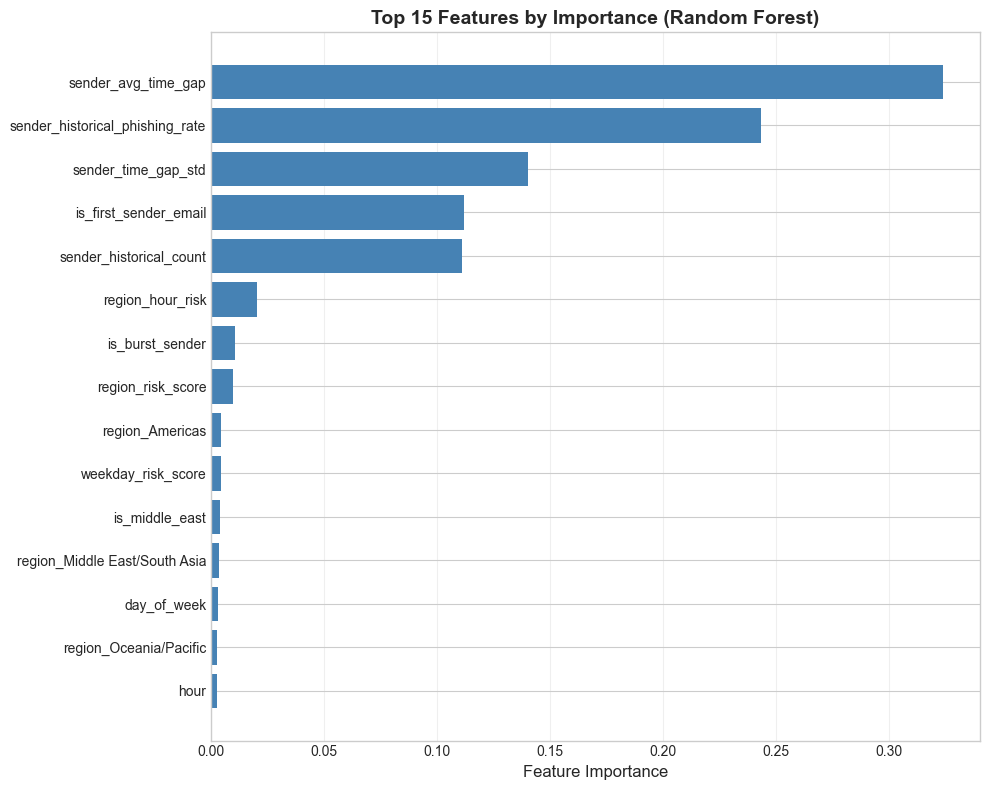

💾 Visualization saved: time_feature_importance.png


In [15]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Features by Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('time_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Visualization saved: time_feature_importance.png")

## 2.3 Evaluation Method 2: Statistical Significance Tests

Test if features show significant difference between normal and phishing emails

In [16]:
print("="*80)
print("EVALUATION METHOD 2: STATISTICAL SIGNIFICANCE TESTS")
print("="*80)

# Use original features (before one-hot encoding)
features_original = [col for col in df_final.columns if col != 'label']

# Separate normal and phishing
normal = df_final[df_final['label'] == 0]
spam = df_final[df_final['label'] == 1]

print(f"\n📊 Sample sizes:")
print(f"   Normal (0): {len(normal):,}")
print(f"   Phishing (1): {len(spam):,}")

sig_results = []

print(f"\n🧪 Running statistical tests...")

for feature in features_original:
    if feature == 'timezone_region':
        # Chi-square test for categorical
        contingency_table = pd.crosstab(df_final[feature], df_final['label'])
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        test_name = 'Chi-square'
    else:
        # T-test for numeric
        normal_vals = normal[feature].dropna()
        spam_vals = spam[feature].dropna()
        t_stat, p_value = stats.ttest_ind(normal_vals, spam_vals)
        test_name = 'T-test'
    
    sig_results.append({
        'feature': feature,
        'test': test_name,
        'p_value': p_value,
        'significant': 'Yes' if p_value < 0.05 else 'No',
        'stars': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
    })

sig_df = pd.DataFrame(sig_results).sort_values('p_value')

print(f"\n📊 STATISTICAL SIGNIFICANCE RESULTS:")
print("="*80)
print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05")
print("-"*80)
print(sig_df.to_string(index=False))

# Summary
n_significant = sig_df[sig_df['significant'] == 'Yes'].shape[0]
print(f"\n✅ Significant features (p < 0.05): {n_significant}/{len(features_original)}")

non_sig = sig_df[sig_df['significant'] == 'No']
if len(non_sig) > 0:
    print(f"\n⚠️  Non-significant features (p ≥ 0.05):")
    print(non_sig[['feature', 'p_value']].to_string(index=False))
else:
    print(f"\n✅ All features are statistically significant!")

EVALUATION METHOD 2: STATISTICAL SIGNIFICANCE TESTS

📊 Sample sizes:
   Normal (0): 21,397
   Phishing (1): 27,406

🧪 Running statistical tests...

📊 STATISTICAL SIGNIFICANCE RESULTS:
Significance levels: *** p<0.001, ** p<0.01, * p<0.05
--------------------------------------------------------------------------------
                        feature       test  p_value significant stars
                timezone_region Chi-square   0.0000         Yes   ***
              region_risk_score     T-test   0.0000         Yes   ***
                 is_middle_east     T-test   0.0000         Yes   ***
sender_historical_phishing_rate     T-test   0.0000         Yes   ***
        sender_historical_count     T-test   0.0000         Yes   ***
          is_first_sender_email     T-test   0.0000         Yes   ***
                is_burst_sender     T-test   0.0000         Yes   ***
               region_hour_risk     T-test   0.0000         Yes   ***
                hour_risk_score     T-test   0.0000

## 2.4 Evaluation Method 3: Information Value (Optional)

Calculate IV scores for numeric features

In [17]:
print("="*80)
print("EVALUATION METHOD 3: INFORMATION VALUE (OPTIONAL)")
print("="*80)

def calculate_iv(df, feature, target='label', bins=10):
    """
    Calculate Information Value
    IV < 0.02: Useless
    IV 0.02-0.1: Weak
    IV 0.1-0.3: Medium
    IV 0.3-0.5: Strong
    IV > 0.5: Suspicious
    """
    try:
        df_temp = df[[feature, target]].copy().dropna()
        
        # For binary or small cardinality, don't bin
        if df_temp[feature].nunique() <= 5:
            df_temp['bin'] = df_temp[feature]
        else:
            df_temp['bin'] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')
        
        # Calculate WOE and IV
        grouped = df_temp.groupby('bin')[target].agg(['count', 'sum'])
        grouped['non_target'] = grouped['count'] - grouped['sum']
        
        total_target = grouped['sum'].sum()
        total_non_target = grouped['non_target'].sum()
        
        grouped['pct_target'] = grouped['sum'] / total_target
        grouped['pct_non_target'] = grouped['non_target'] / total_non_target
        
        # Avoid division by zero
        grouped['pct_target'] = grouped['pct_target'].replace(0, 0.0001)
        grouped['pct_non_target'] = grouped['pct_non_target'].replace(0, 0.0001)
        
        grouped['woe'] = np.log(grouped['pct_target'] / grouped['pct_non_target'])
        grouped['iv'] = (grouped['pct_target'] - grouped['pct_non_target']) * grouped['woe']
        
        return grouped['iv'].sum()
    except:
        return np.nan

print(f"\n📊 Calculating Information Value...")

iv_results = []
for feature in features_original:
    if feature != 'timezone_region':  # Skip categorical
        iv = calculate_iv(df_final, feature)
        strength = (
            'Suspicious' if iv > 0.5 else
            'Strong' if iv >= 0.3 else
            'Medium' if iv >= 0.1 else
            'Weak' if iv >= 0.02 else
            'Useless'
        )
        iv_results.append({
            'feature': feature,
            'IV': iv,
            'strength': strength
        })

iv_df = pd.DataFrame(iv_results).sort_values('IV', ascending=False)

print(f"\n📊 INFORMATION VALUE RESULTS:")
print("="*80)
print("IV Interpretation: <0.02=Useless, 0.02-0.1=Weak, 0.1-0.3=Medium, 0.3-0.5=Strong, >0.5=Suspicious")
print("-"*80)
print(iv_df.to_string(index=False))

# Summary by strength
print(f"\n📊 IV Summary:")
iv_summary = iv_df['strength'].value_counts()
for strength, count in iv_summary.items():
    print(f"   {strength}: {count}")

EVALUATION METHOD 3: INFORMATION VALUE (OPTIONAL)

📊 Calculating Information Value...

📊 INFORMATION VALUE RESULTS:
IV Interpretation: <0.02=Useless, 0.02-0.1=Weak, 0.1-0.3=Medium, 0.3-0.5=Strong, >0.5=Suspicious
--------------------------------------------------------------------------------
                        feature     IV   strength
            sender_avg_time_gap 4.3685 Suspicious
            sender_time_gap_std 3.4049 Suspicious
          is_first_sender_email 3.0498 Suspicious
        sender_historical_count 2.7542 Suspicious
                is_burst_sender 1.3943 Suspicious
               region_hour_risk 0.8001 Suspicious
              region_risk_score 0.7346 Suspicious
                 is_middle_east 0.3741     Strong
sender_historical_phishing_rate 0.3547     Strong
                hour_risk_score 0.1064     Medium
                           hour 0.0848       Weak
                    day_of_week 0.0191    Useless
             weekday_risk_score 0.0185    Useless
      

## 2.5 Feature Selection: Automatic Selection

Combine all evaluation results and **automatically determine the optimal number** of features using:

### Selection Criteria:
1. **Statistical significance:** p-value < 0.05
2. **Minimum importance:** Feature importance > 0.01
3. **Optimal count determination:**
   - Method A: Elbow point (largest drop in marginal importance)
   - Method B: 80% cumulative importance threshold
   - **Final:** Conservative choice (minimum of the two)
   - Constrained to 5-15 features

### Why Automatic?
- Adapts to your specific dataset
- Balances model complexity vs. performance
- Avoids arbitrary cutoffs


In [18]:
print("="*80)
print("COMBINING RESULTS & AUTOMATIC FEATURE SELECTION")
print("="*80)

# Start with importance scores
combined = importance_df.copy()

# For one-hot encoded features, aggregate back to original
if any(f.startswith('region_') for f in combined['feature'].values):
    region_features = [f for f in combined['feature'] if f.startswith('region_')]
    region_importance = combined[combined['feature'].isin(region_features)]['importance'].sum()
    
    # Remove individual region features
    combined = combined[~combined['feature'].isin(region_features)]
    
    # Add combined timezone_region importance
    combined = pd.concat([
        combined,
        pd.DataFrame([{'feature': 'timezone_region', 'importance': region_importance}])
    ], ignore_index=True)
    combined = combined.sort_values('importance', ascending=False).reset_index(drop=True)

# Merge with significance
combined = combined.merge(
    sig_df[['feature', 'p_value', 'significant', 'stars']], 
    on='feature', 
    how='left'
)

# Merge with IV
if len(iv_results) > 0:
    combined = combined.merge(
        iv_df[['feature', 'IV', 'strength']], 
        on='feature', 
        how='left'
    )

print(f"\n📊 COMBINED EVALUATION RESULTS:")
print("="*80)
print(combined.to_string(index=False))

# Apply selection criteria
print(f"\n🎯 Selection Criteria:")
print(f"   1. Feature must be statistically significant (p < 0.05)")
print(f"   2. Feature importance > 0.01")
print(f"   3. Automatically determine optimal number using cumulative importance")

# Filter by significance and importance threshold
filtered = combined[
    (combined['significant'] == 'Yes') & 
    (combined['importance'] > 0.01)
].sort_values('importance', ascending=False).reset_index(drop=True)

print(f"\n✅ Features passing criteria: {len(filtered)}")

# Calculate cumulative importance
filtered['cumulative_importance'] = filtered['importance'].cumsum() / filtered['importance'].sum()

# Method 1: Find elbow point (largest drop in marginal importance)
if len(filtered) > 2:
    marginal_importance = filtered['importance'].values
    importance_drops = np.diff(marginal_importance)
    # Normalize drops
    importance_drops_norm = importance_drops / marginal_importance[:-1]
    # Find largest relative drop
    elbow_idx = np.argmax(importance_drops_norm) + 1
    
    # Method 2: 80% cumulative threshold
    threshold_80_idx = (filtered['cumulative_importance'] >= 0.80).idxmax()
    
    # Use the more conservative (smaller) of the two
    optimal_n = min(elbow_idx, threshold_80_idx + 1)
    
    # Ensure at least 5 features, max 15
    optimal_n = max(5, min(optimal_n, 15))
else:
    optimal_n = len(filtered)

print(f"\n📈 Automatic Selection Analysis:")
print(f"   • Elbow point method: {elbow_idx} features")
print(f"   • 80% cumulative threshold: {threshold_80_idx + 1} features")
print(f"   • Selected (conservative): {optimal_n} features")

# Select optimal features
selected_features = filtered.head(optimal_n)

print(f"\n" + "="*80)
print(f"🏆 AUTOMATICALLY SELECTED {optimal_n} FEATURES")
print("="*80)

for i, row in selected_features.iterrows():
    cumul_pct = row['cumulative_importance'] * 100
    iv_str = f" | IV: {row['IV']:.3f}" if 'IV' in row and not pd.isna(row['IV']) else ""
    print(f"{i+1:2d}. {row['feature']:45s} | Imp: {row['importance']:.4f} ({cumul_pct:5.1f}%) | p: {row['p_value']:.2e} {row['stars']}{iv_str}")

# Save results
selected_feature_list = selected_features['feature'].tolist()

print(f"\n📊 Selection Summary:")
print(f"   • Total features evaluated: {len(combined)}")
print(f"   • Features passing criteria: {len(filtered)}")
print(f"   • Features selected: {len(selected_features)}")
print(f"   • Cumulative importance captured: {selected_features['cumulative_importance'].iloc[-1]:.1%}")
print(f"   • Average importance per feature: {selected_features['importance'].mean():.4f}")

# Store in a variable for later use
final_selected_features = selected_feature_list
print(f"\n✅ Selected features stored in variable: final_selected_features")

COMBINING RESULTS & AUTOMATIC FEATURE SELECTION

📊 COMBINED EVALUATION RESULTS:
                        feature  importance  p_value significant stars     IV   strength
            sender_avg_time_gap      0.3241   0.5433          No       4.3685 Suspicious
sender_historical_phishing_rate      0.2433   0.0000         Yes   *** 0.3547     Strong
            sender_time_gap_std      0.1404   0.0000         Yes   *** 3.4049 Suspicious
          is_first_sender_email      0.1119   0.0000         Yes   *** 3.0498 Suspicious
        sender_historical_count      0.1112   0.0000         Yes   *** 2.7542 Suspicious
                timezone_region      0.0411   0.0000         Yes   ***    NaN        NaN
                is_burst_sender      0.0107   0.0000         Yes   *** 1.3943 Suspicious
             weekday_risk_score      0.0045   0.0000         Yes   *** 0.0185    Useless
                 is_middle_east      0.0038   0.0000         Yes   *** 0.3741     Strong
                    day_of_wee

## 2.6 Comprehensive Visualizations

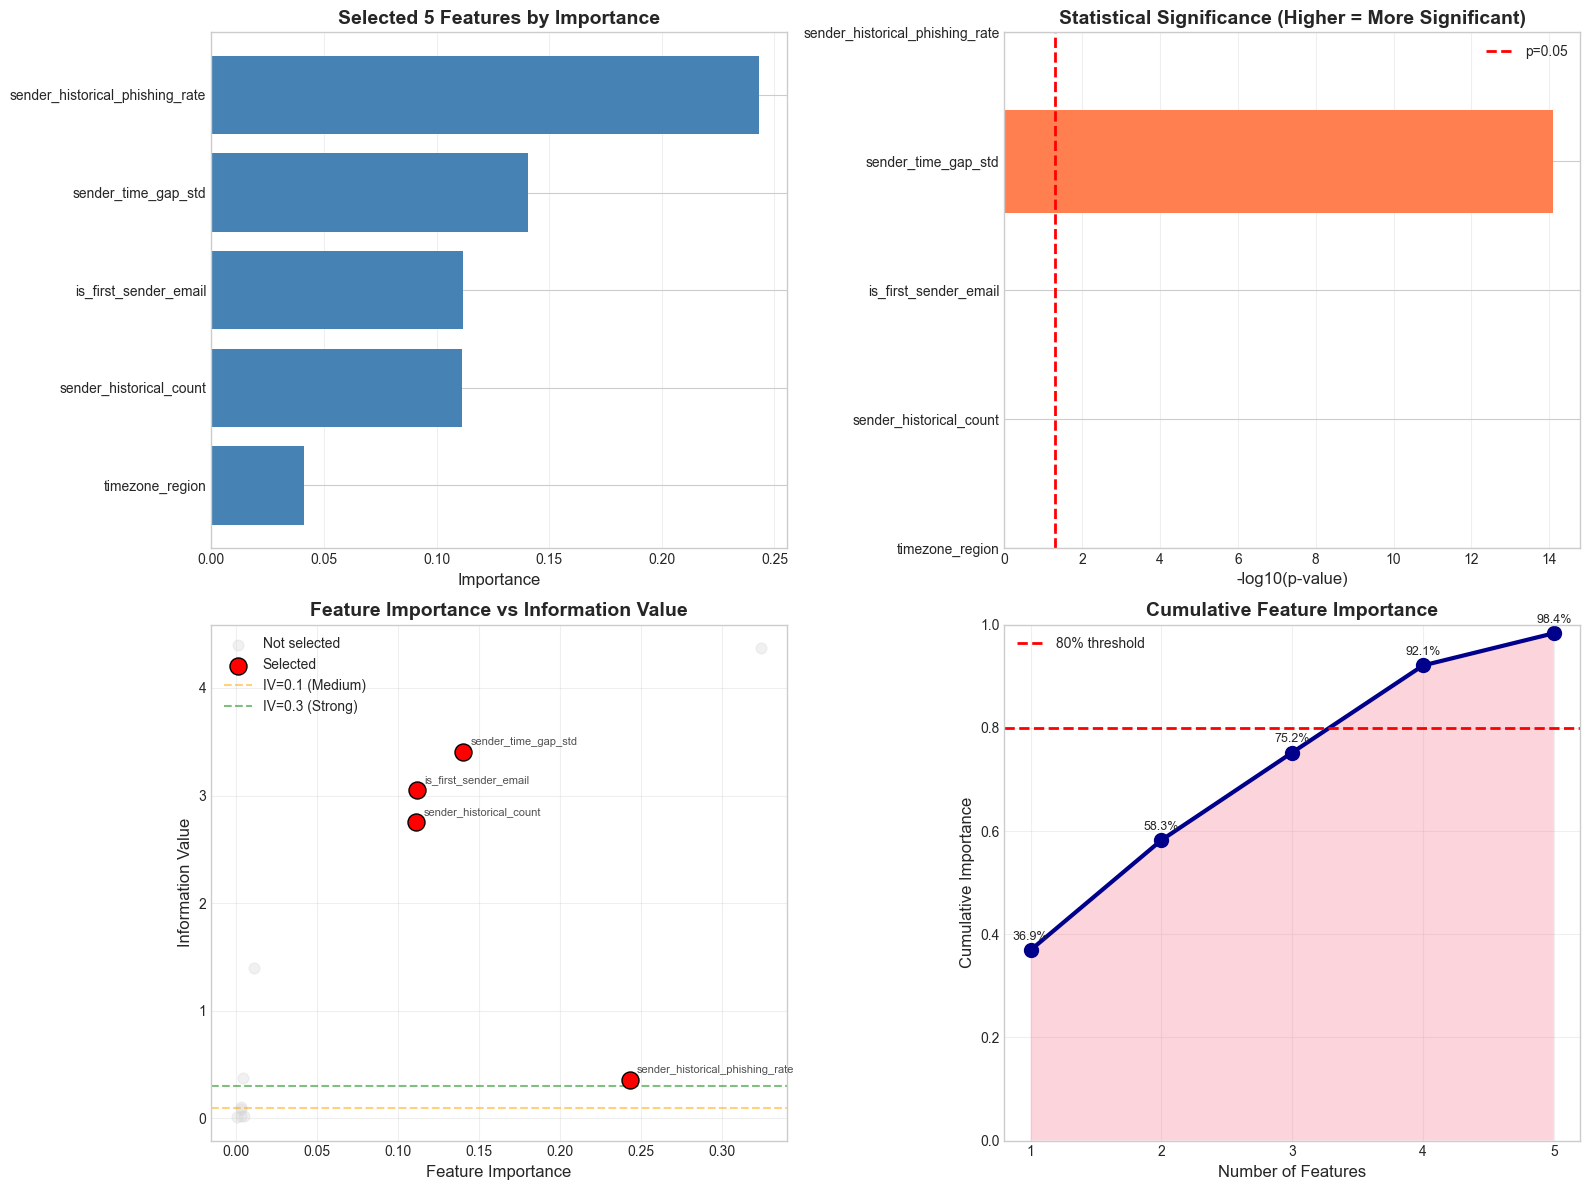


💾 Visualization saved: feature_evaluation_summary.png
   Showing 5 automatically selected features


In [19]:
# Create comprehensive visualization for selected features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Selected Feature Importance
axes[0, 0].barh(range(len(selected_features)), selected_features['importance'], color='steelblue')
axes[0, 0].set_yticks(range(len(selected_features)))
axes[0, 0].set_yticklabels(selected_features['feature'])
axes[0, 0].set_xlabel('Importance', fontsize=12)
axes[0, 0].set_title(f'Selected {len(selected_features)} Features by Importance', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Statistical Significance
axes[0, 1].barh(range(len(selected_features)), -np.log10(selected_features['p_value']), color='coral')
axes[0, 1].set_yticks(range(len(selected_features)))
axes[0, 1].set_yticklabels(selected_features['feature'])
axes[0, 1].set_xlabel('-log10(p-value)', fontsize=12)
axes[0, 1].set_title('Statistical Significance (Higher = More Significant)', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05')
axes[0, 1].invert_yaxis()
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Importance vs IV scatter (show all features, highlight selected)
if 'IV' in combined.columns:
    # Plot all features in gray
    axes[1, 0].scatter(combined['importance'], combined['IV'], alpha=0.3, s=60, color='lightgray', label='Not selected')
    # Highlight selected features
    for idx, row in selected_features.iterrows():
        if not pd.isna(row.get('IV')):
            axes[1, 0].scatter(row['importance'], row['IV'], color='red', s=150, zorder=5, edgecolors='black', label='Selected' if idx == 0 else '')
            # Only annotate selected features
            axes[1, 0].annotate(row['feature'], (row['importance'], row['IV']), 
                              fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')
    
    axes[1, 0].set_xlabel('Feature Importance', fontsize=12)
    axes[1, 0].set_ylabel('Information Value', fontsize=12)
    axes[1, 0].set_title('Feature Importance vs Information Value', fontsize=14, fontweight='bold')
    axes[1, 0].axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='IV=0.1 (Medium)')
    axes[1, 0].axhline(y=0.3, color='green', linestyle='--', alpha=0.5, label='IV=0.3 (Strong)')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

# 4. Cumulative importance
cumsum = selected_features['cumulative_importance'].values
axes[1, 1].plot(range(1, len(selected_features)+1), cumsum, marker='o', linewidth=3, markersize=10, color='darkblue')
axes[1, 1].fill_between(range(1, len(selected_features)+1), cumsum, alpha=0.3)
axes[1, 1].set_xlabel('Number of Features', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Importance', fontsize=12)
axes[1, 1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
axes[1, 1].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='80% threshold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(range(1, len(selected_features)+1))
axes[1, 1].set_ylim(0, 1)

# Add percentage labels
for i, pct in enumerate(cumsum, 1):
    axes[1, 1].text(i, pct + 0.02, f'{pct:.1%}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('feature_evaluation_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Visualization saved: feature_evaluation_summary.png")
print(f"   Showing {len(selected_features)} automatically selected features")

## ✅ FEATURE EVALUATION COMPLETE!

### Summary Statistics

The evaluation process has:
1. ✅ Evaluated all 15 engineered features
2. ✅ Applied statistical significance testing
3. ✅ Calculated feature importance scores
4. ✅ Computed Information Value (IV) for predictive power
5. ✅ Automatically selected optimal features

### Next Steps:
- The selected features are stored in `final_selected_features`
- Use these features for model training
- The engineered dataset is saved for downstream tasks

### How to Use Results:
```python
# The automatically selected features are in:
print(final_selected_features)

# Go back to Cell 22 to save the dataset with selected features
```


In [20]:
print("="*80)
print("✅ FEATURE EVALUATION COMPLETE!")
print("="*80)

print(f"\n📊 Summary:")
print(f"   • Features evaluated: {len(features_original)}")
print(f"   • Statistically significant: {n_significant}/{len(features_original)}")
print(f"   • Features automatically selected: {len(selected_features)}")
print(f"   • Average importance: {selected_features['importance'].mean():.4f}")
print(f"   • Total importance captured: {selected_features['cumulative_importance'].iloc[-1]:.1%}")

print(f"\n🏆 Selected Features:")
for i, feature in enumerate(final_selected_features, 1):
    print(f"   {i:2d}. {feature}")

print(f"\n🎯 Next Steps:")
print(f"   1. Use the selected features for model training")
print(f"   2. Prepare training dataset:")
print(f"      X = df_final[final_selected_features]")
print(f"      y = df_final['label']")
print(f"   3. Train classification models (RF, XGBoost, LogReg)")
print(f"   4. Evaluate and compare performance")

print("\n" + "="*80)

✅ FEATURE EVALUATION COMPLETE!

📊 Summary:
   • Features evaluated: 15
   • Statistically significant: 13/15
   • Features automatically selected: 5
   • Average importance: 0.1296
   • Total importance captured: 98.4%

🏆 Selected Features:
    1. sender_historical_phishing_rate
    2. sender_time_gap_std
    3. is_first_sender_email
    4. sender_historical_count
    5. timezone_region

🎯 Next Steps:
   1. Use the selected features for model training
   2. Prepare training dataset:
      X = df_final[final_selected_features]
      y = df_final['label']
   3. Train classification models (RF, XGBoost, LogReg)
   4. Evaluate and compare performance

